In [1]:
#track test
import sys, os
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii","underpinnings")))
from notebook_log_loading import load_sensor_log_file
from id_to_name import id_to_name
sensor_log,first_timestamp=load_sensor_log_file("../to_study/servo_calib.txt")


In [36]:
import numpy as np
time_ref=None
gyro_vecs=[]
int_gyro_vec=[]
gyro_vec_ts=[]

det_ts=[]
sportsball_ycenter=[]

servo_ts=[]
servo_angles=[]

for message in sensor_log:
    if "packets" in message:
        for packet in message['packets']:
            if time_ref==None:
                time_ref=-message['timestamp']+message['packets'][-1]['gyroscope_timestamp']
            time_ref=max(time_ref,-message['timestamp']+message['packets'][-1]['gyroscope_timestamp'])

            if 'gyroscope' in packet:
                #gyro_vec_ts.append(entry["timestamp"]-first_timestamp     -(entry['packets'][-1]["gyroscope_timestamp"]-packet["gyroscope_timestamp"]))
                
                gyro_vecs.append(packet["gyroscope"])
                if len(int_gyro_vec)==0:
                    int_gyro_vec.append(np.array([0,0,0]))
                else:
                    int_gyro_vec.append(int_gyro_vec[-1]+(gyro_vec_ts[-1]-packet["gyroscope_timestamp"])*np.array(packet["gyroscope"]))
                    
                gyro_vec_ts.append(packet["gyroscope_timestamp"])
                
                #gyro_norm.append( np.linalg.norm(np.array(packet["gyroscope"])))
                #delta_t.append(packet["gyroscope_timestamp"]-entry["timestamp"])
    if 'detections' in message:
        for det in message['detections']:
            if det["label"]=="sports ball":
                det_ts.append(message["image_timestamp"])
                #print(det)
                sportsball_ycenter.append(0.5*(det["bbox_array"][1]+det["bbox_array"][3]))  
    if 'servo_response' in message:
        servo_ts.append(message['timestamp']+time_ref)
        servo_angles.append(message['servo_response']['angle'])
            
        
gyro_vecs=np.array(gyro_vecs)                
int_gyro_vec=np.array(int_gyro_vec)
sportsball_ycenter=np.array(sportsball_ycenter)


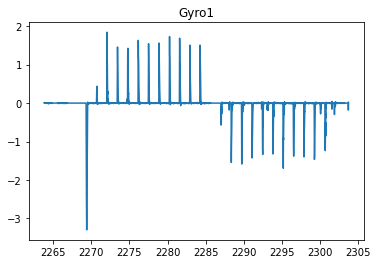

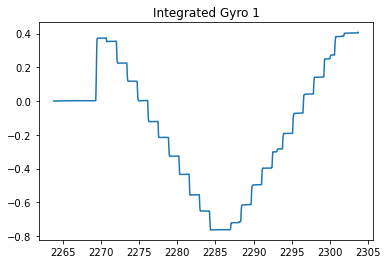

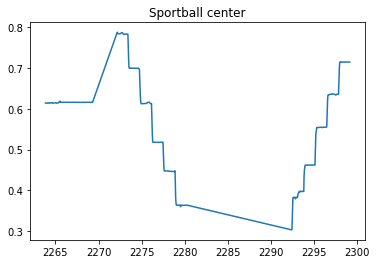

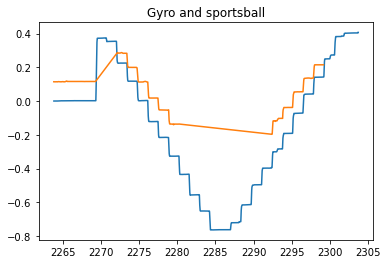

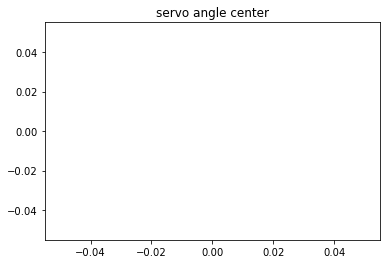

In [35]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
plt.title("Gyro1")
ax.plot(gyro_vec_ts,gyro_vecs[:,1]) #element 1 is the right one for head tilt
plt.show()

fig, ax = plt.subplots()
plt.title("Integrated Gyro 1")
ax.plot(gyro_vec_ts,int_gyro_vec[:,1]) #element 1 is the right one for head tilt
plt.show()

fig, ax = plt.subplots()
plt.title("Sportball center")
ax.plot(det_ts,sportsball_ycenter) #element 1 is the right one for head tilt
plt.show()

fig, ax = plt.subplots()
plt.title("Gyro and sportsball")
ax.plot(gyro_vec_ts,int_gyro_vec[:,1]) #element 1 is the right one for head tilt
ax.plot(det_ts,sportsball_ycenter-0.5) #element 1 is the right one for head tilt
plt.show()

fig, ax = plt.subplots()
plt.title("servo angle center")
ax.plot(servo_ts,servo_angles,'*') #element 1 is the right one for head tilt
plt.show()

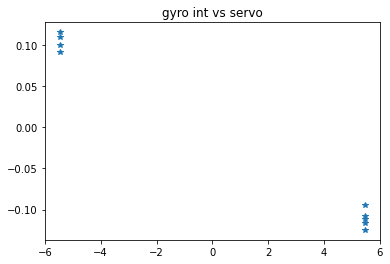

det vs servo -0.014730808291881337 +- 0.0005898803058100422


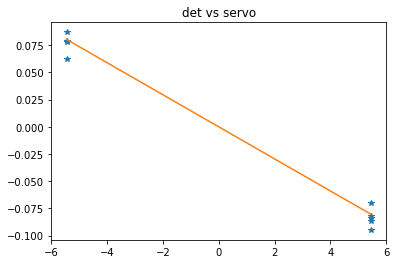

det vs intgyro 0.746358221573594 +- 0.009428091112310804


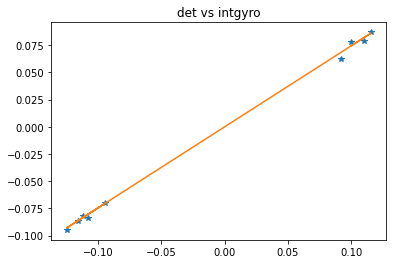

In [49]:
from scipy.optimize import curve_fit
#so I want a plot of:

def get_within(target_t,ts,vs,min_dt):
    for i in range(len(ts)-1):
        if ts[i]<target_t and ts[i+1]>target_t:
            if abs(ts[i]-target_t)<min_dt:
                return vs[i]
            else:
                return None
    return None

def get_delta(target_t,ts,vs,min_dt,deltat):
    a=get_within(target_t+deltat,ts,vs,min_dt)
    b=get_within(target_t-deltat,ts,vs,min_dt)
    if a is None or b is None:
        return None
    return a-b

last_servo=None
array_servo_changes=[]
array_intgyro_changes=[]
array_det_changes=[]
for i in range(len(servo_ts)):    
    if last_servo is None:
        last_servo=servo_angles[i]
        continue
        
    step=0.2
    min_dt=0.1
    
    delta_servo=servo_angles[i]-last_servo
    t=servo_ts[i]
    delta_intgyro=get_delta(t,gyro_vec_ts,int_gyro_vec,min_dt,step)[1]
    delta_det=get_delta(t,det_ts,sportsball_ycenter,min_dt,step)
    last_servo=servo_angles[i]
    
    if delta_det is None or delta_intgyro is None:
        continue
    
    array_servo_changes.append(delta_servo)
    array_intgyro_changes.append(delta_intgyro)
    array_det_changes.append(delta_det)
    
array_servo_changes=np.array(array_servo_changes)
array_intgyro_changes=np.array(array_intgyro_changes)
array_det_changes=np.array(array_det_changes)
    
    
def slope_fit(x,a):
    return x*a
    
fig, ax = plt.subplots()
plt.title("gyro int vs servo")
ax.plot(array_servo_changes,array_intgyro_changes,'*') #element 1 is the right one for head tilt
plt.show()

popt,pcov=curve_fit(slope_fit,array_servo_changes,array_det_changes)
print("det vs servo {} +- {}".format(popt[0],np.sqrt(pcov[0][0])))

fig, ax = plt.subplots()
plt.title("det vs servo")
ax.plot(array_servo_changes,array_det_changes,'*') #element 1 is the right one for head tilt
ax.plot(array_servo_changes,slope_fit(array_servo_changes,popt[0])) #element 1 is the right one for head tilt
plt.show()

popt,pcov=curve_fit(slope_fit,array_intgyro_changes,array_det_changes)

print("det vs intgyro {} +- {}".format(popt[0],np.sqrt(pcov[0][0])))


fig, ax = plt.subplots()
plt.title("det vs intgyro")
ax.plot(array_intgyro_changes,array_det_changes,'*') #element 1 is the right one for head tilt
ax.plot(array_intgyro_changes,slope_fit(array_intgyro_changes,popt[0])) #element 1 is the right one for head tilt
plt.show()
    
    
        